<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Pareto_NBD_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [294]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [295]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import plotly.express as px
import xlrd
import pandas as pd
import warnings
import lifetimes
import dill as pickle
from sklearn.cluster import KMeans
from lifetimes import ParetoNBDFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from sklearn.metrics import mean_squared_error, r2_score
import math
from math import sqrt
warnings.filterwarnings("ignore")
import datetime
np.random.seed(42)

In [296]:
data = pd.read_excel("Retail_cleaned_dataset.xlsx")

In [297]:
data["TotalPrice"] = data["Quantity"]*data["Price"]
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']).dt.date

In [298]:
print(data['InvoiceDate'].min())
print(data['InvoiceDate'].max())

2019-12-01
2021-12-09


In [299]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2019-12-01,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2019-12-01,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2019-12-01,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2019-12-01,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2019-12-01,1.25,13085,United Kingdom,30.0


In [300]:
# number of customers
data['CustomerID'].nunique()

5878

In [301]:
# number of transactions
data.shape

(779428, 9)

In [302]:
cust = data.groupby(['CustomerID']).agg({
    'Invoice': 'count',
    'TotalPrice': 'sum'
}).reset_index()

In [303]:
cust.describe()

,CustomerID,Invoice,TotalPrice
count,5878.000000,5878.000000,5878.000000
mean,15315.313542,132.600885,2955.906009
std,1715.572666,342.191398,14440.853611
min,12346.000000,1.000000,2.950000
25%,13833.250000,20.000000,342.280000
50%,15314.500000,52.000000,867.740000
75%,16797.750000,138.000000,2248.305000
max,18287.000000,12435.000000,580987.040000


In [304]:
rfm_summary = lifetimes.utils.summary_data_from_transaction_data(data, "CustomerID", "InvoiceDate", "TotalPrice")

In [305]:
rfm_summary.reset_index(inplace = True)

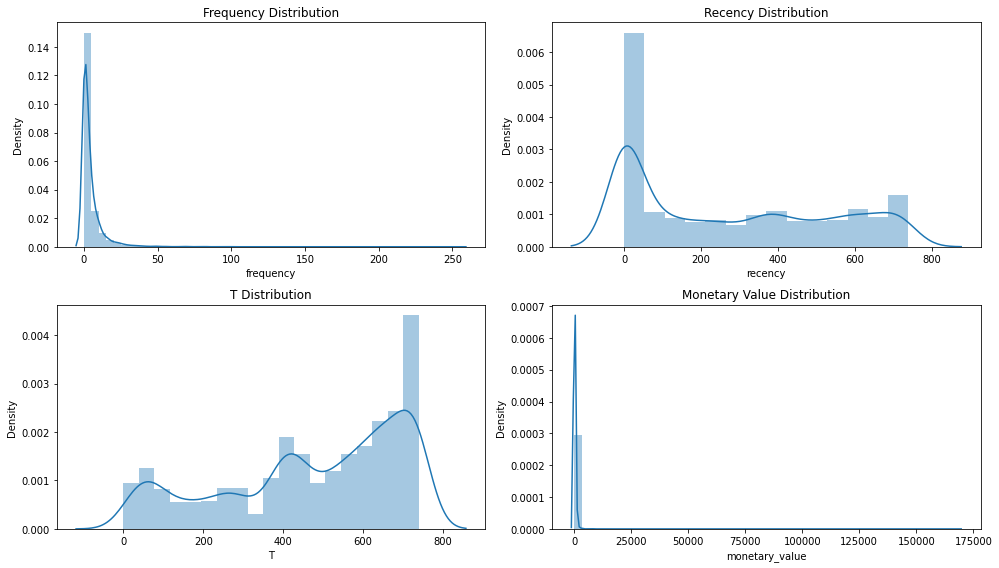

In [306]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(rfm_summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(rfm_summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(rfm_summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(rfm_summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

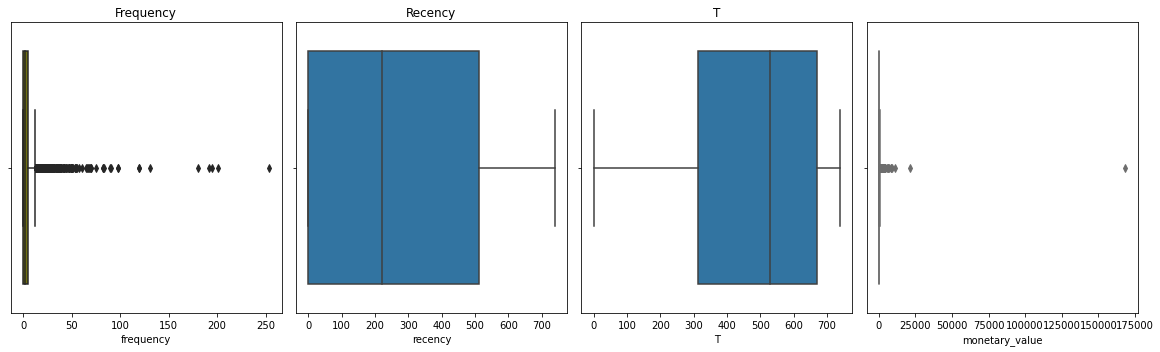

In [307]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(rfm_summary["frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(rfm_summary["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(rfm_summary["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(rfm_summary["monetary_value"], color = "salmon")

plt.tight_layout()

In [308]:
rfm_summary.describe(percentiles = [0.01,0.1,0.25,0.50,0.75,0.90,0.99])

,CustomerID,frequency,recency,T,monetary_value
count,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000
mean,15315.313542,4.632358,273.647669,474.551718,312.996561
std,1715.572666,9.999783,259.242435,223.394778,2255.743170
min,12346.000000,0.000000,0.000000,0.000000,0.000000
1%,12405.770000,0.000000,0.000000,15.000000,0.000000
10%,12936.700000,0.000000,0.000000,89.000000,0.000000
25%,13833.250000,0.000000,0.000000,313.000000,0.000000
50%,15314.500000,2.000000,221.000000,530.000000,207.117500
75%,16797.750000,5.000000,512.000000,669.000000,368.045909
90%,17696.300000,11.000000,668.000000,731.000000,591.139417


In [309]:
rfm_summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346,7.0,401.0,726.0,11066.637143
1,12347,7.0,402.0,404.0,615.714286
2,12348,4.0,363.0,438.0,449.310000
3,12349,3.0,571.0,589.0,1120.056667
4,12350,0.0,0.0,310.0,0.000000


**Pareto/NBD Model**

In [310]:
def get_model(data, penalizer_val, time):
    
    pareto_result = data.copy()

    pareto_model = ParetoNBDFitter(penalizer_coef = penalizer_val)
    pareto_model.fit(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

    #calculating the predicted_purchases

    t = time

    pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])


    pareto_result["Actual_Purchases"] = pareto_result["frequency"]/pareto_result["recency"]*time

    #filling the null values
    pareto_result["Actual_Purchases"].fillna(0, inplace = True)


    #calculating the error
    pareto_result["Prediction_Error"] = pareto_result["Actual_Purchases"]-pareto_result["predicted_purchases"]

    #calcuating the purchase prediction error
    pareto_mse_purchase = mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_r2_purchase = r2_score(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_rmse_purchase = sqrt(mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"]))
    pareto_avg_error_purchase = pareto_result["Prediction_Error"].mean()
    
    #printing the purchase prediction error
    print("Predicted Purchase Mean Squared Error: %s" %(pareto_mse_purchase))
    print("Predicted Purchase R2 Score: %s" %(pareto_r2_purchase))
    print("Predicted Purchase Root Mean Squared Error: %s" %(pareto_rmse_purchase))
    print("Predicted Purchase Average Purchases Error: %s" %(pareto_avg_error_purchase))
    
    
    #plotting the prediction v/s actual purchase plot
    plt.figure(figsize=(6,4))
    plt.errorbar(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"], yerr=pareto_result["Prediction_Error"], fmt='o', color='darkseagreen',
                 ecolor='grey', elinewidth=1.5, capsize=0, alpha = 0.2);
    plt.title("Prediction v/s Actual")

Predicted Purchase Mean Squared Error: 2.2178054572100874
Predicted Purchase R2 Score: 0.060510353555273455
Predicted Purchase Root Mean Squared Error: 1.4892298201453285
Predicted Purchase Average Purchases Error: 0.23184043664196166


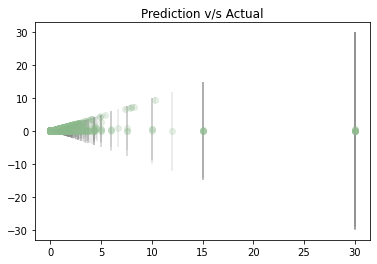

In [311]:
get_model(rfm_summary, 0.001, 30)

In [312]:
pareto_model = lifetimes.ParetoNBDFitter(penalizer_coef = 0.1)

In [313]:
pareto_model.fit(rfm_summary["frequency"],rfm_summary["recency"],
                rfm_summary["T"])

<lifetimes.ParetoNBDFitter: fitted with 5878 subjects, alpha: 72.03, beta: 385.66, r: 0.74, s: 0.18>

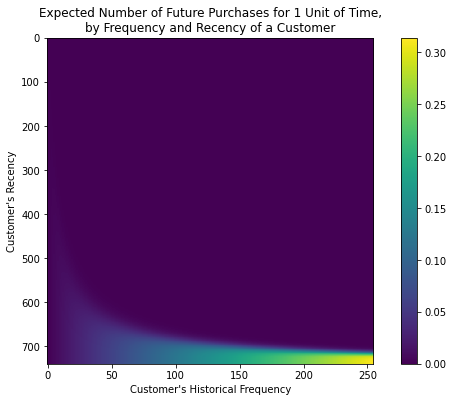

In [314]:
plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(pareto_model)

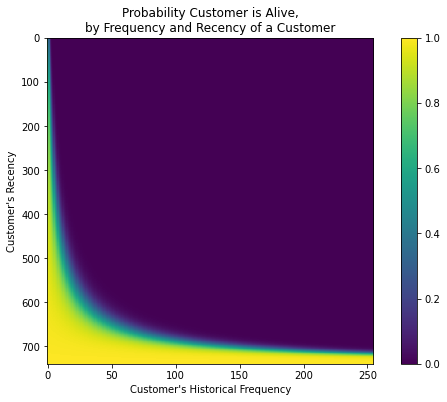

In [315]:
plt.figure(figsize=(10,6))
plot_probability_alive_matrix(pareto_model)

In [316]:
pareto_result = rfm_summary.copy()

In [317]:
pareto_result["p_not_alive"] = 1-pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])
pareto_result["p_alive"] = pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [318]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288


In [319]:
t = 30
pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [320]:
pareto_result

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288,0.048093
...,...,...,...,...,...,...,...,...
5873,18283,18.0,656.0,659.0,142.666667,0.000541,0.999459,0.766602
5874,18284,0.0,0.0,431.0,0.000000,0.222904,0.777096,0.034122
5875,18285,0.0,0.0,661.0,0.000000,0.309941,0.690059,0.020808
5876,18286,1.0,248.0,724.0,833.480000,0.201957,0.798043,0.052165


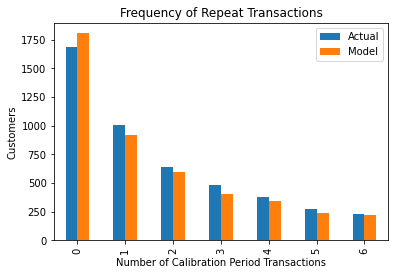

In [321]:
plot_period_transactions(pareto_model)

In [322]:
#dividing our dataset into training & holdout
pareto_summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2021-06-08',
                                                  observation_period_end = '2021-12-09')

In [323]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,401.0,542.0,0.0,184.0
12347,3.0,158.0,220.0,4.0,184.0
12348,3.0,190.0,254.0,1.0,184.0
12349,2.0,182.0,405.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0


In [324]:
pareto_model.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"])

<lifetimes.ParetoNBDFitter: fitted with 4966 subjects, alpha: 74.34, beta: 1657.15, r: 0.74, s: 0.69>

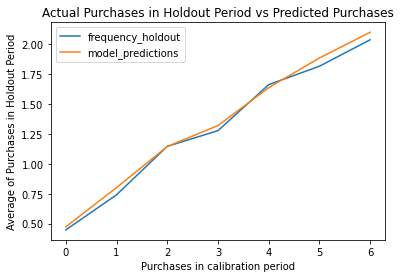

In [325]:
plot_calibration_purchases_vs_holdout_purchases(pareto_model, pareto_summary_cal_holdout)

In [326]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,401.0,542.0,0.0,184.0
12347,3.0,158.0,220.0,4.0,184.0
12348,3.0,190.0,254.0,1.0,184.0
12349,2.0,182.0,405.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0


In [327]:
pareto_result["actual30"] = pareto_result["frequency"]/pareto_result["recency"]*30

In [328]:
pareto_result["actual30"].fillna(0, inplace = True)

In [329]:
pareto_result["error"] = pareto_result["actual30"]-pareto_result["predicted_purchases"]

In [330]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288,0.048093,0.000000,-0.048093


In [331]:
def get_metrics(true, predicted, error):
    
    print("Mean Squared Error: %s"%(mean_squared_error(true, predicted)))
    print("Root Mean Squared Error: %s"%(sqrt(mean_squared_error(true, predicted))))
    print("R2 Score: %s"%(r2_score(true, predicted)))
    
    sns.scatterplot(true, predicted, size = error, color = "darkolivegreen")
    plt.title("Actual Purchase v/s Predicted Purchase")
    plt.show()

Mean Squared Error: 2.2178118875611887
Root Mean Squared Error: 1.489231979095664
R2 Score: 0.060507629579523825


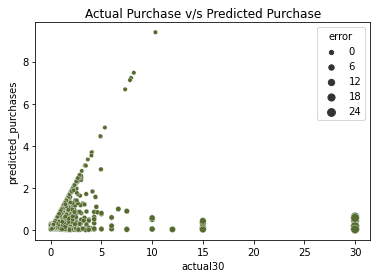

In [332]:
get_metrics(pareto_result["actual30"], pareto_result["predicted_purchases"], pareto_result["error"])

In [333]:
#Get the history alive plot to check whether the customer is alive or not

def get_history_alive(t_, data_, id_):
    
    individual_alive = data[data["CustomerID"] == id_]
    plot_history_alive(pareto_model, t = t_, transactions = individual_alive, datetime_col = "InvoiceDate",
                  freq = "D")

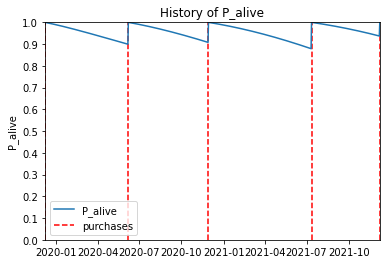

In [334]:
get_history_alive(30, data, 12358.0)

**GAMMA-GAMMA MODEL**

In [335]:
returning_customers_summary = pareto_result[pareto_result['frequency']>0]

In [336]:
# 64% customer left
len(returning_customers_summary)/len(pareto_result)

0.7126573664511738

In [337]:
ggf_model  =  lifetimes.GammaGammaFitter(penalizer_coef=0.1)

In [338]:
ggf_model .fit(returning_customers_summary["frequency"], returning_customers_summary["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 1.02, q: 0.18, v: 0.93>

In [339]:
ggf_model .summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.019926,0.024531,0.971846,1.068006
q,0.179152,0.002996,0.173280,0.185023
v,0.933467,0.025489,0.883508,0.983426


In [340]:
returning_customers_summary["expected_avg_sales_"] = ggf_model.conditional_expected_average_profit(returning_customers_summary["frequency"],\
                                                                                     returning_customers_summary["monetary_value"])

In [341]:
returning_customers_summary.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915
6,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899


In [342]:
print("Mean Squared Error: %s" %(mean_squared_error(returning_customers_summary["monetary_value"], returning_customers_summary["expected_avg_sales_"])))
print("Root Mean Squared Error: %s" %(sqrt(mean_squared_error(returning_customers_summary["monetary_value"], returning_customers_summary["expected_avg_sales_"]))))
print("R2 Score: %s" %(r2_score(returning_customers_summary["monetary_value"], returning_customers_summary["expected_avg_sales_"])))

Mean Squared Error: 118447363.6217067
Root Mean Squared Error: 10883.352591077195
R2 Score: -15.721908585813079


In [343]:
returning_customers_summary["predicted_clv"] = ggf_model.customer_lifetime_value(pareto_model,
                                                       returning_customers_summary["frequency"],
                                                       returning_customers_summary["recency"],
                                                       returning_customers_summary["T"],
                                                       returning_customers_summary["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [344]:
#Top 5 customers with high CLV
returning_customers_summary[["CustomerID", "predicted_clv"]].sort_values(by = "predicted_clv", ascending = False).head(5)

,CustomerID,predicted_clv
4061,16446,3.648665e+06
5692,18102,5.063031e+05
2277,14646,4.550215e+05
189,12536,3.649551e+05
5050,17450,2.887334e+05


In [345]:
# Assuming 5% of Profit Margin
returning_customers_summary["profit_margin"] = returning_customers_summary["predicted_clv"]*0.05

In [346]:
returning_customers_summary.reset_index().drop("index", axis = 1, inplace = True)

In [347]:
#exporting the result to csv
returning_customers_summary.to_csv("customer_lifetime_value_prediction.csv")

**CUSTOMER SEGMENTATION USING PREDICTED CLV**

In [348]:
returning_customers_summary.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869,35772.183774,1788.609189
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861,7706.961492,385.348075
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388,3444.569575,172.228479
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915,5935.296147,296.764807
6,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899,4742.312084,237.115604


In [349]:
col = ["predicted_purchases", "expected_avg_sales_", "predicted_clv", "profit_margin"]

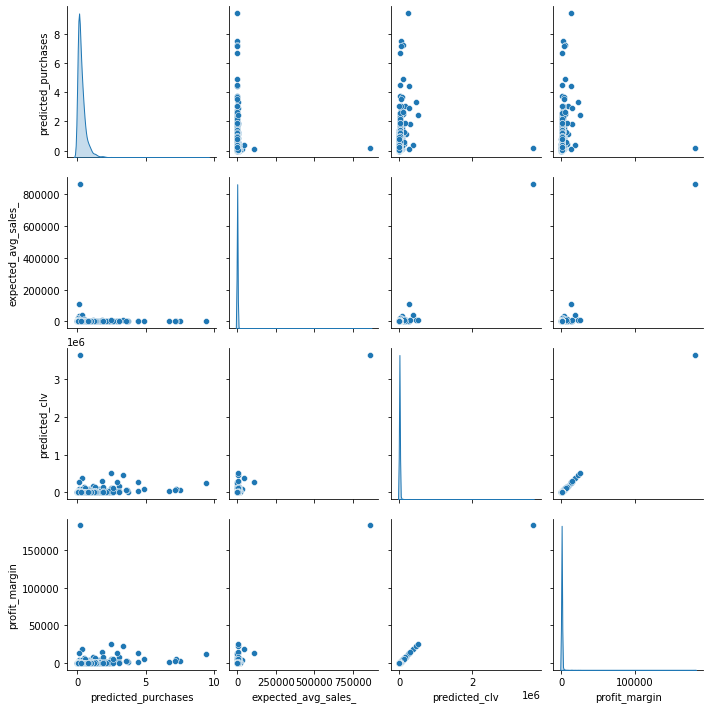

In [350]:
sns.pairplot(returning_customers_summary[col], diag_kind = "kde")

In [351]:
new_df = returning_customers_summary[col]
print(new_df)

      predicted_purchases  expected_avg_sales_  predicted_clv  profit_margin
0                0.155209         12504.444869   35772.183774    1788.609189
1                0.485818           695.851861    7706.961492     385.348075
2                0.270791           562.775388    3444.569575     172.228479
3                0.168606          1531.122915    5935.296147     296.764807
6                0.556060           376.226899    4742.312084     237.115604
...                   ...                  ...            ...            ...
5871             0.076241           418.843596     717.724659      35.886233
5872             0.261352           403.576306    2360.076127     118.003806
5873             0.766602           149.398389    2643.111517     132.155576
5876             0.052165          4274.910277    4711.693787     235.584689
5877             0.264345           741.876901    4485.643822     224.282191

[4189 rows x 4 columns]


In [352]:
inertia = []

for i in range(1, 11):
    kmeans  = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(new_df)
    inertia.append(kmeans.inertia_)

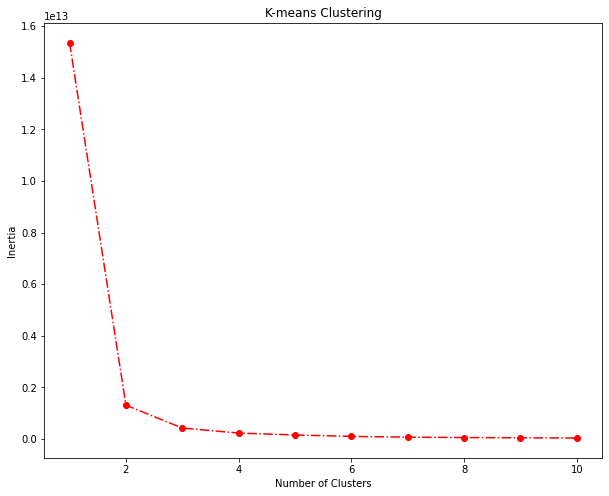

In [353]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), inertia, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-means Clustering')
plt.show()

In [354]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [355]:
labels=kmeans.fit(new_df)

In [356]:
df_segm_kmeans= new_df.copy()
df_segm_kmeans['Segment K-means'] = kmeans.labels_

In [357]:
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin
Segment K-means,,,,
0,0.324033,758.436149,4.125287e+03,206.264339
1,0.187433,863116.959561,3.648665e+06,182433.244475
2,3.103728,22851.858246,3.348881e+05,16744.406225
3,2.046050,4194.432976,8.002331e+04,4001.165689


In [358]:
df_segm_analysis.rename({0:'Low',
                         1:'Very-High',
                         2:'High',
                         3:'Medium'})

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin
Segment K-means,,,,
Low,0.324033,758.436149,4.125287e+03,206.264339
Very-High,0.187433,863116.959561,3.648665e+06,182433.244475
High,3.103728,22851.858246,3.348881e+05,16744.406225
Medium,2.046050,4194.432976,8.002331e+04,4001.165689


In [359]:
# Add the segment labels to our table
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'Low',
                                                                  1:'Very-High',
                                                                  2:'High',
                                                                  3:'Medium'})

In [360]:
df_segm_kmeans.head()

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin,Segment K-means,Labels
0,0.155209,12504.444869,35772.183774,1788.609189,0,Low
1,0.485818,695.851861,7706.961492,385.348075,0,Low
2,0.270791,562.775388,3444.569575,172.228479,0,Low
3,0.168606,1531.122915,5935.296147,296.764807,0,Low
6,0.556060,376.226899,4742.312084,237.115604,0,Low


In [361]:
ggf_filter = pd.concat([returning_customers_summary,df_segm_kmeans['Segment K-means'],df_segm_kmeans['Labels']], axis = 1)

In [362]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin,Segment K-means,Labels
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869,35772.183774,1788.609189,0,Low
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861,7706.961492,385.348075,0,Low
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388,3444.569575,172.228479,0,Low
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915,5935.296147,296.764807,0,Low
6,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899,4742.312084,237.115604,0,Low


In [363]:
ggf_filter.groupby('Labels').CustomerID.count()/ggf_filter.CustomerID.count()*100

Labels
High          0.190976
Low          98.925758
Medium        0.859394
Very-High     0.023872
Name: CustomerID, dtype: float64

In [364]:
ggf_filter.to_csv("Segmentation_result.csv")

**Machine Learning: Xgboost and Lightgbm Algorithm**

In [365]:
123data.InvoiceDate

SyntaxError: ignored

In [ ]:
import datetime

dfnew_train = data[data.InvoiceDate <= datetime.date(2021, 6, 8)]
dfnew_test = data[data.InvoiceDate > datetime.date(2021, 6, 8)]

maxdate = dfnew_train.InvoiceDate.max()
mindate = dfnew_train.InvoiceDate.min()

dfnew_train['duration'] =  (maxdate - dfnew_train.InvoiceDate)/np.timedelta64(1, 'D')
# get time duration between the last transaction to now
dfsum1 = dfnew_train.groupby(['CustomerID'])['duration'].min().reset_index()
dfsum1.rename(columns = {'duration':'latetime'}, inplace = True)

# get time duration between the first transaction to now
dfsum2 = dfnew_train.groupby(['CustomerID'])['duration'].max().reset_index()
dfsum2.rename(columns = {'duration':'earlytime'}, inplace = True)

# get transaction frequency (whole history)
dfsum3 = dfnew_train.groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum3.rename(columns={'InvoiceDate': 'freq'}, inplace=True)
# get transaction frequency (recent 3 months history)
dfsum4 = dfnew_train[dfnew_train.duration<91].groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum4.rename(columns={'InvoiceDate': 'freq_3m'}, inplace=True)

dfsum = pd.merge(dfsum1, dfsum2, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum3, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum4, on=['CustomerID'], how='outer')

# get target: number of transactions in test set
dfsum_target = dfnew_test.groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum_target.rename(columns={'InvoiceDate': 'target'}, inplace=True)
dfsum = pd.merge(dfsum, dfsum_target, on=['CustomerID'], how='left')
dfsum  = dfsum.fillna(0).sort_values(['target'], ascending = False)

In [ ]:
dfsum.head(10)

**XG Boost Model**

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xgb_model = xgb.XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 3)
 
predictors = ['latetime','earlytime', 'freq','freq_3m']
X = dfsum[predictors]
y = dfsum.target

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

xgb_model.fit(x_trains, y_train)

In [ ]:
y_pred = xgb_model.predict(x_valids)
rmse = mean_squared_error(y_valid, y_pred)**(1/2)
print('RMSE on test set: ', rmse)

In [ ]:
xgb_model2 = xgb.XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 3)
xgb_model2.fit(X, y)
y_pred2 = xgb_model2.predict(X)
print('RMSE: ', mean_squared_error(y, y_pred2)**(1/2))
print('SMAPE', smape(y, y_pred2))
print('R2: ', r2_score(y, y_pred2))

**Feature Importance**

In [ ]:
xgb.plot_importance(xgb_model, importance_type='gain')

In [ ]:
xgb.plot_importance(xgb_model, importance_type='weight')

In [ ]:
import lightgbm as lgb

lgbparams = {
    'n_estimators': 2200, 
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',    
    'max_depth': 3, 
    'learning_rate': 0.02
}

lgb_model = lgb.LGBMRegressor(**lgbparams)
 
predictors = ['latetime','earlytime', 'freq','freq_3m']
X = dfsum[predictors]
y = dfsum.target

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

lgb_model.fit(x_trains, y_train)

In [ ]:
y_pred = lgb_model.predict(x_valids)
rmse = mean_squared_error(y_valid, y_pred)**(1/2)
print('RMSE on test set: ', rmse)

In [ ]:
lgb.plot_importance(lgb_model, importance_type='gain')

In [ ]:
lgb.plot_importance(lgb_model) # defualt: weight

In [ ]:
lgb_model2 = lgb.LGBMRegressor(**lgbparams)
lgb_model2.fit(X, y)
y_pred3 = lgb_model2.predict(X)
print('RMSE: ', mean_squared_error(y, y_pred3)**(1/2))
print('SMAPE', smape(y, y_pred3))
print('R2: ', r2_score(y, y_pred3))